April 2018

_Is MSAN making me fat?_ An exercise in modelling weight fluctuations across a year of master's studies for n = 1 (Ong) subjects. 

Data collected from July 2017 to early-April 2018 (9.5 months) is used to forecast values from April to June 2018 (2.5 months).

Topics explored include:  
- Mean, last-observation-carried-forward, and linear interpolation imputation methods for missing data
- Time series model selection methods 
- The time series model training, validation, and prediction pipeline 
- Univariate vs. multivariate (WIP) time series models

## Univariate Modelling

In [133]:
suppressMessages(install.packages("vars", "/Users/booranium/anaconda/lib/R/library"))

_Note on the above: for those not familiar with running R in Jupyter, I am installing the package `vars` the way one usually would in R, making sure to install it into the R library being used by Jupyter. See [this](https://www.datacamp.com/community/blog/jupyter-notebook-r) helpful Datacamp link for using R in Jupyter._

In [1]:
options(warn=-1)
suppressMessages(library(imputeTS))
suppressMessages(library(forecast))
suppressMessages(library(vars))
suppressMessages(library(repr))
suppressMessages(library(ggplot2))

In [4]:
data <- read.csv('/Users/booranium/projects/weight/weight.csv', header = T)
data = data[!is.na(data$week_flag),]  # remove extra rows where all cols = NA 
ts_weight_raw = as.ts(data$weight, start = c(2017, 7, 1), frequency = 365.25)  # specifies daily data 

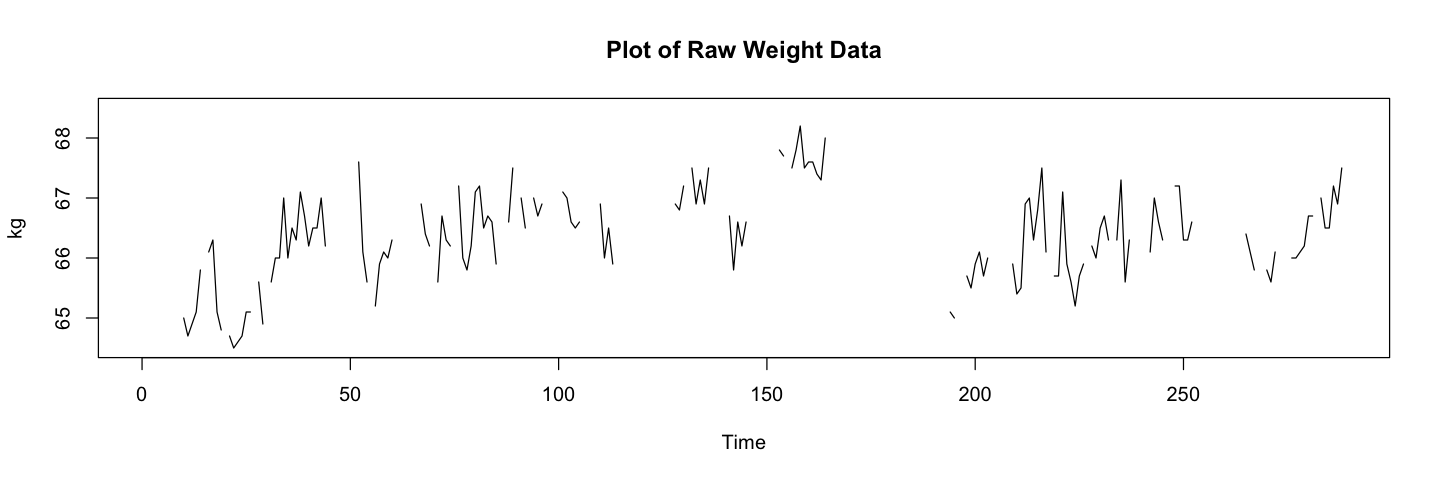

In [105]:
options(repr.plot.width=12, repr.plot.height=4) # set plot settings for entire notebook
plot(ts_weight_raw, main = "Plot of Raw Weight Data", ylab = 'kg', ylim = c(64.5, 68.5))

Notice the large amount of missing data-- approximately 41%. This needs to be taken care before modelling. Unlike other scenarios, we cannot simply discard observations with missing data as we are here working with a time series and need to respect the dependent nature of observations.  

The alternative to discarding missing data is imputation: the process of replacing missing data with substituted values. Some common methods include:

- random value imputation
- mean/median value imputation
- last observation carried forward (LOCF)/next observation carried backward (NOCB)
- linear/spline interpolation

Consider the examples plotted below (dashed lines indicate imputed values)

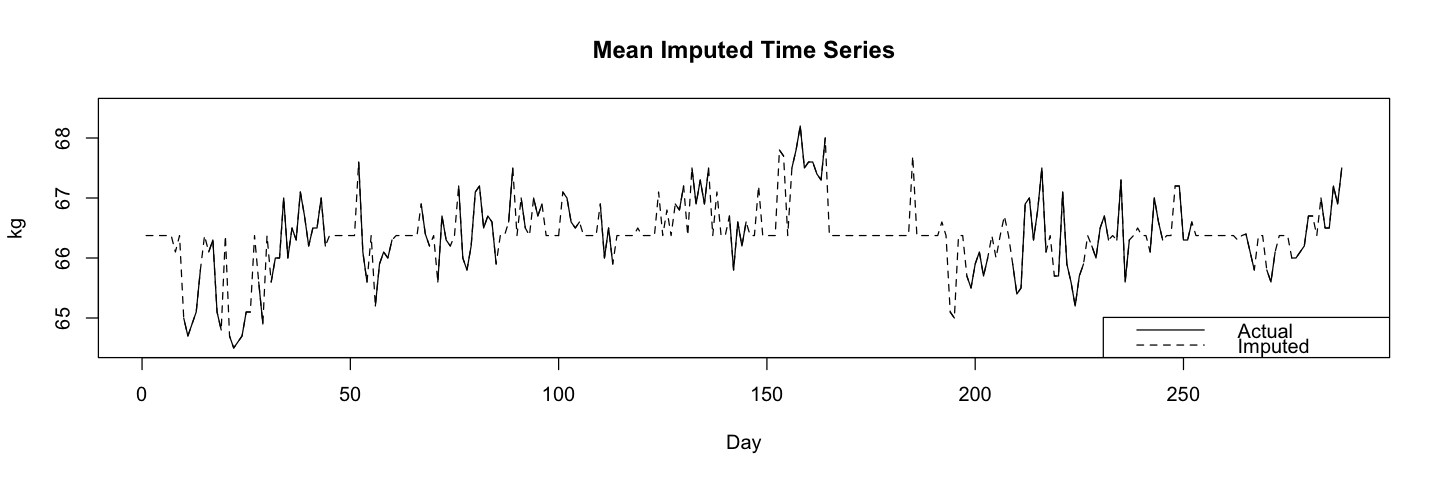

In [106]:
ts_weight_mean = na.mean(ts_weight_raw, option = 'mean')
plot(ts_weight_raw, ylim = c(64.5, 68.5), 
     xlab = 'Day', ylab = "kg", main = "Mean Imputed Time Series")
lines(ts_weight_mean, lty = 'dashed')
legend('bottomright', legend=c("Actual", "Imputed"), lty= c('solid', 'dashed'), y.intersp=1.5)

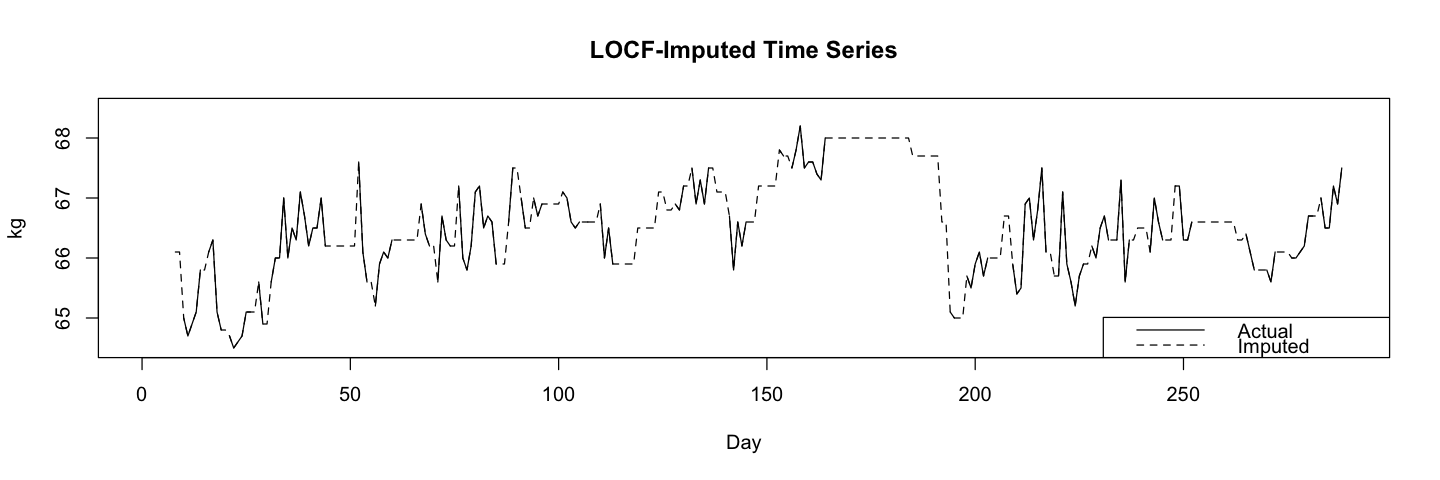

In [108]:
ts_weight_locf = na.locf(ts_weight_raw, option = "locf")
plot(ts_weight_raw, ylim = c(64.5, 68.5), 
     xlab = 'Day', ylab = "kg", main = "LOCF-Imputed Time Series")
lines(ts_weight_locf, lty = 'dashed')
legend('bottomright', legend=c("Actual", "Imputed"), lty= c('solid', 'dashed'), y.intersp=1.5)

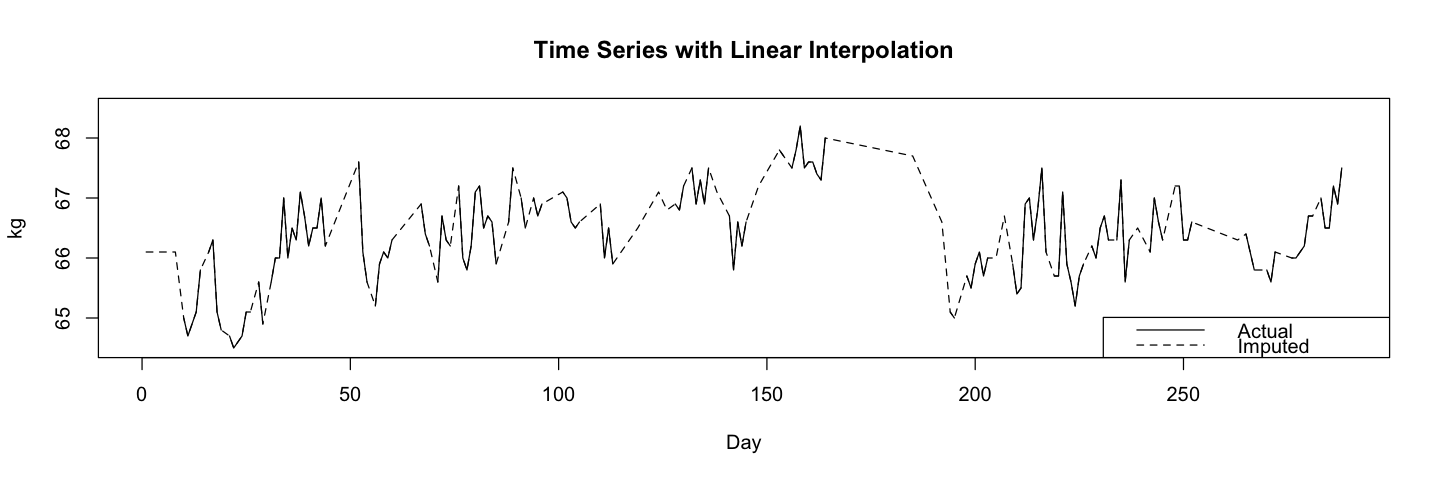

In [191]:
ts_weight_lin = na.interpolation(ts_weight_raw, option = "linear")
plot(ts_weight_raw, ylim = c(64.5, 68.5), 
     xlab = 'Day', ylab = "kg", main = "Time Series with Linear Interpolation")
lines(ts_weight_lin, lty = 'dashed')
legend('bottomright', legend=c("Actual", "Imputed"), lty= c('solid', 'dashed'), y.intersp=1.5)

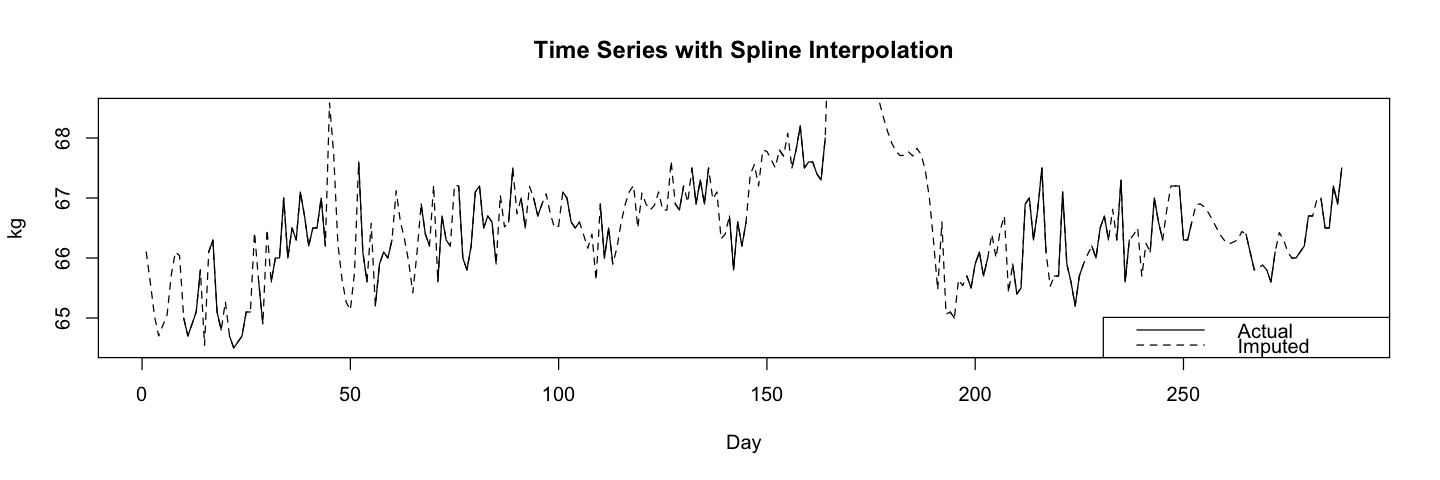

In [56]:
ts_weight_spline = na.interpolation(ts_weight_raw, option = "spline")
plot(ts_weight_raw, ylim = c(64.5, 68.5), 
     xlab = 'Day', ylab = "kg", main = "Time Series with Spline Interpolation")
lines(ts_weight_spline, lty = 'dashed')
legend('bottomright', legend=c("Actual", "Imputed"), lty= c('solid', 'dashed'), y.intersp=1.5)

All four plots have the same y-axis range: 64.5 to 68.5kg. Notice that spline interpolation produces estimates around Days 49 and 175 that are off the charts. While spline interpolation is often successful because of its flexibility, in our case, given the relatively large gaps of data (several days in a row), this flexibility seems to be introducing too a large a degree of variation. I say this with confidence given (my) prior knowledge that(my) weight rarely exceeds 68.0 kg.

In what follows, I use mean, LOCF and linear interpolation imputation methods to create univariate models for forecasting. The data is split into training (first 7 months) and validation (last 2.5 months), chosen such that the length of the validation set is the same amount of time we want to forecast for. 

In [88]:
ndays = 365-length(ts_weight_raw)  # days left to predict = length of test set 
train_stop = length(ts_weight_raw)-ndays  # length of train set = data - test

train_mean = head(ts_weight_mean, train_stop)
test_mean = tail(ts_weight_mean, ndays)

train_locf = head(ts_weight_locf, train_stop)
test_locf = tail(ts_weight_locf, ndays)

train_lin = head(ts_weight_lin, train_stop)
test_lin = tail(ts_weight_lin, ndays)



### Mean Imputation

It is clear from the plots of the raw and imputed time series that it is not stationary. Not only are there fluctuations from day to day, but there is (sadly) an overall upward trend in the fluctuations, as indicated by the red regression line below.

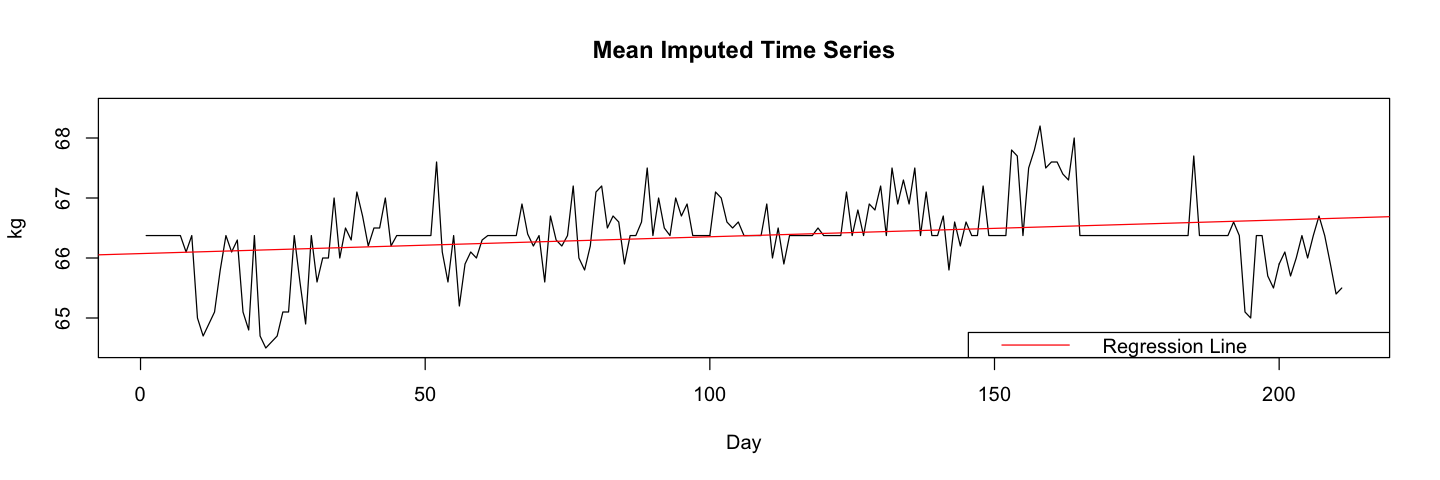

In [192]:
x = c(1:length(train_mean))
y = train_mean
out = lm(y~x)

plot(train_mean, typ = 'l', ylim = c(64.5, 68.5), xlab = 'Day', ylab = 'kg', main = "Mean Imputed Time Series")
abline(out, col = 'red')
legend('bottomright', legend=c("Regression Line"), lty= c('solid'), col = c('red'), y.intersp=1.5)

This means we need to perform [differencing](https://robjhyndman.com/talks/RevolutionR/8-Differencing.pdf). Consider the plot below of the time series with one-round of differencing:

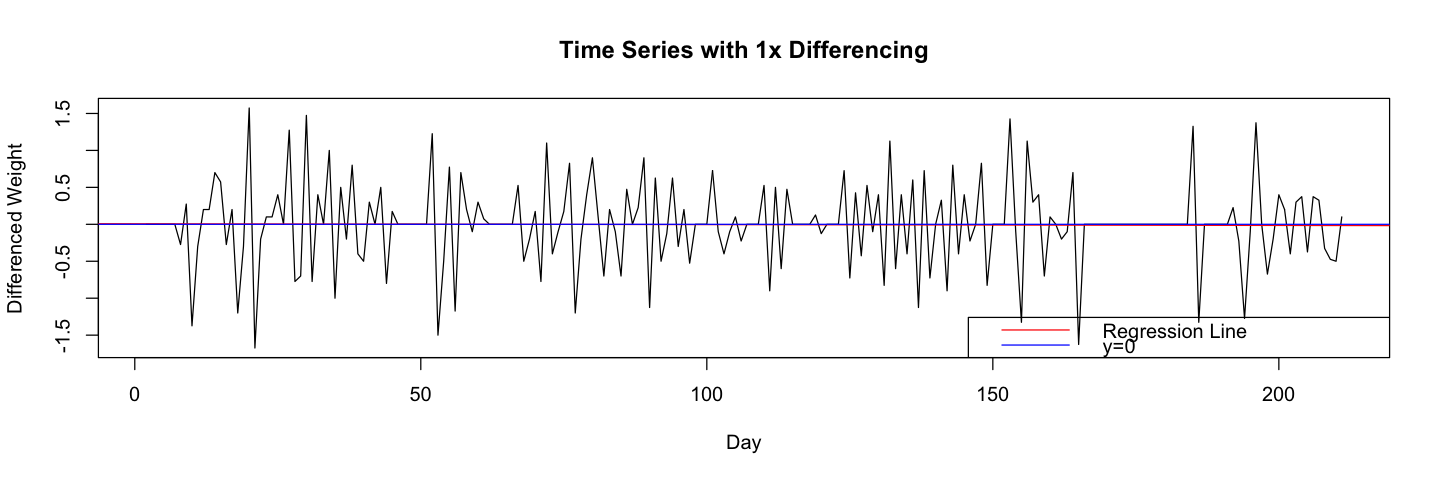

In [181]:
train_mean_d1 = diff(train_mean)
x_d1 = c(1: length(train_mean_d1))  # recalculated because differencing removes on observation 
out_d1 = lm(train_mean_d1 ~ x_d1)

plot(train_mean_d1, 
     xlab = 'Day', ylab = 'Differenced Weight', main = "Time Series with 1x Differencing")
abline(out_d1, col = 'red')
abline(h=0, col='blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=1.5)

The time series is more or less trend-stationary. The red regression line and the blue horizontal line at y=0 overlap significantly. The plot below zooms in to the range [-0.1, 0.1] on the y-axis and shows that the regression line is just slightly tilted downward from y=0.

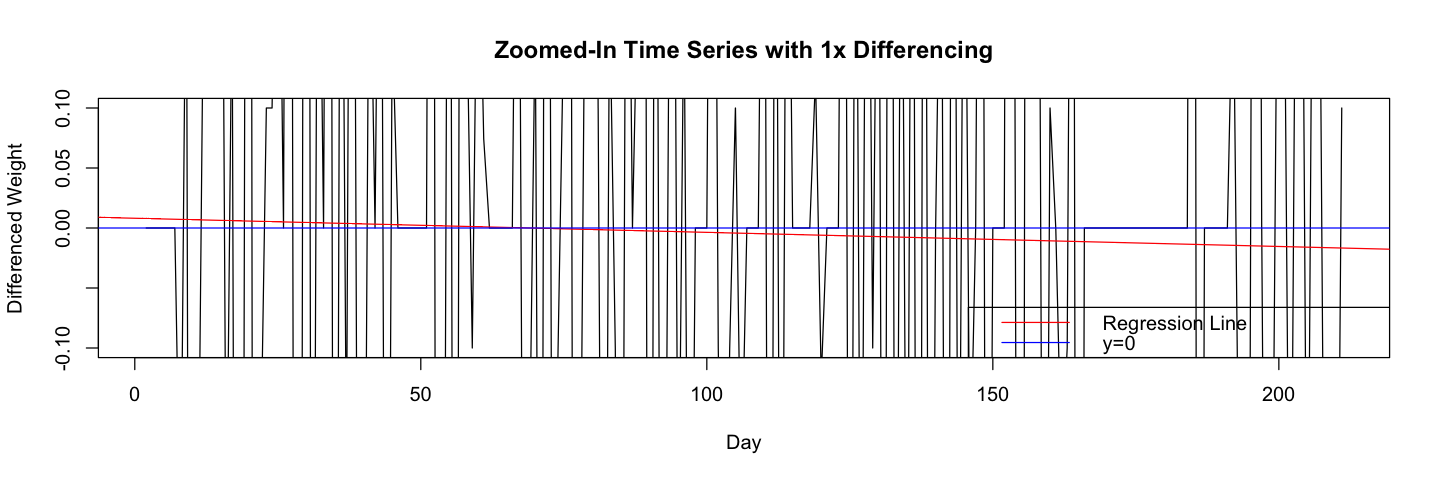

In [184]:
plot(train_mean_d1, ylim = c(-0.1, 0.1), 
     xlab = 'Day', ylab = 'Differenced Weight', main = "Zoomed-In Time Series with 1x Differencing")
abline(out_d1, col = 'red')
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'),lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

We conclude that one round of differencing is sufficient to render the time series trend stationary. This can also be formalized using functions such as `ndiffs` to find the number of rounds of differencing needed or `adf.test` to test if the resulting time series is stationary.

While trend has been eliminated, there is still seasonality in the data, i.e. cyclical patterns in the variance of the data across time. This is evident from the plot of the time series above as the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots below. (ACF and PACF plots show the correlation and partial correlation of a time series with itself at different time lags.)

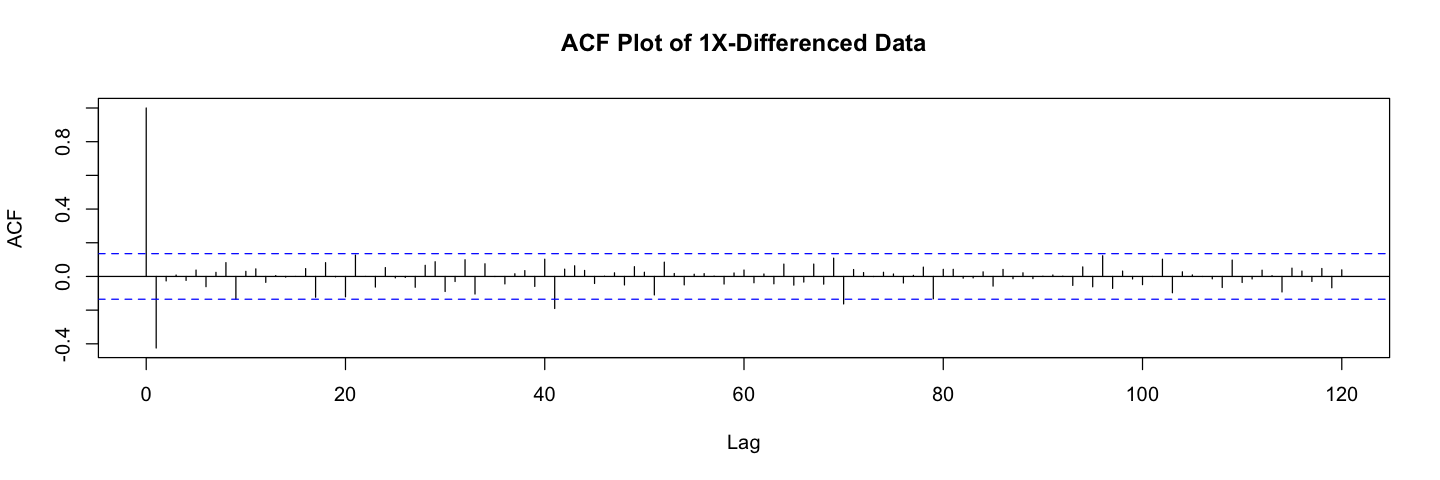

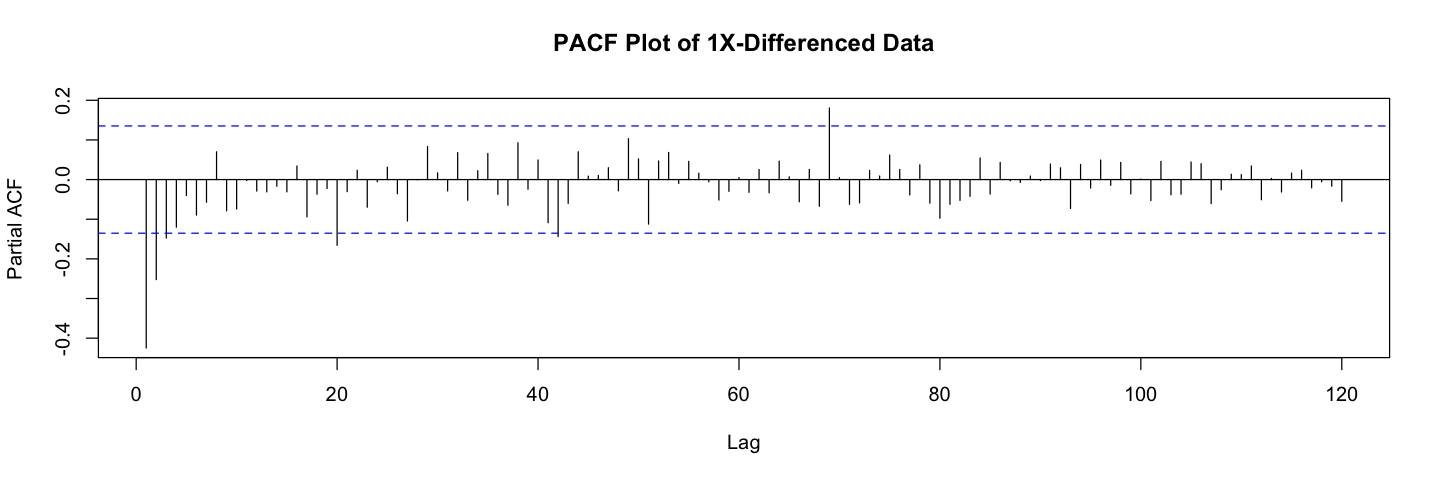

In [142]:
acf(train_mean_d1, lag.max = 120, main = 'ACF Plot of 1X-Differenced Data')
pacf(train_mean_d1, lag.max = 120, main = 'PACF Plot of 1X-Differenced Data')

Using a seasonal autoregressive integrated moving average (SARIMA) model, we try to model this seasonal variation using large orders P and Q.  

The model selection process involves trying different parameter options, and using visual checks and residual analysis to assess model fit. We look for a model that fits the data well and residuals that no longer exhibit correlation. (Since residuals represent variation in the data not captured by the model, uncorrelated residuals indicate that the model successfully captured the correlation in the data.)

The checks used are:

- Plots of residuals vs. time: indicate trend (or lack thereof) in the residuals 
- Ljung-Box statistic: indicate correlatedness (or lack thereof) of residuals at several time lags simultaneously
- QQ-plot of the residuals: indicate normality (or lack thereof)  in the residuals 
- `shapiro.test`: indicate independence (or lack thereof)  in the residuals

After iterating through various options, the following model is chosen:

In [ ]:
m_mean = arima(train_mean, order = c(0,1,1), seasonal = list(order = c(5, 2, 5), period = 14))

The model fit is plotted below:

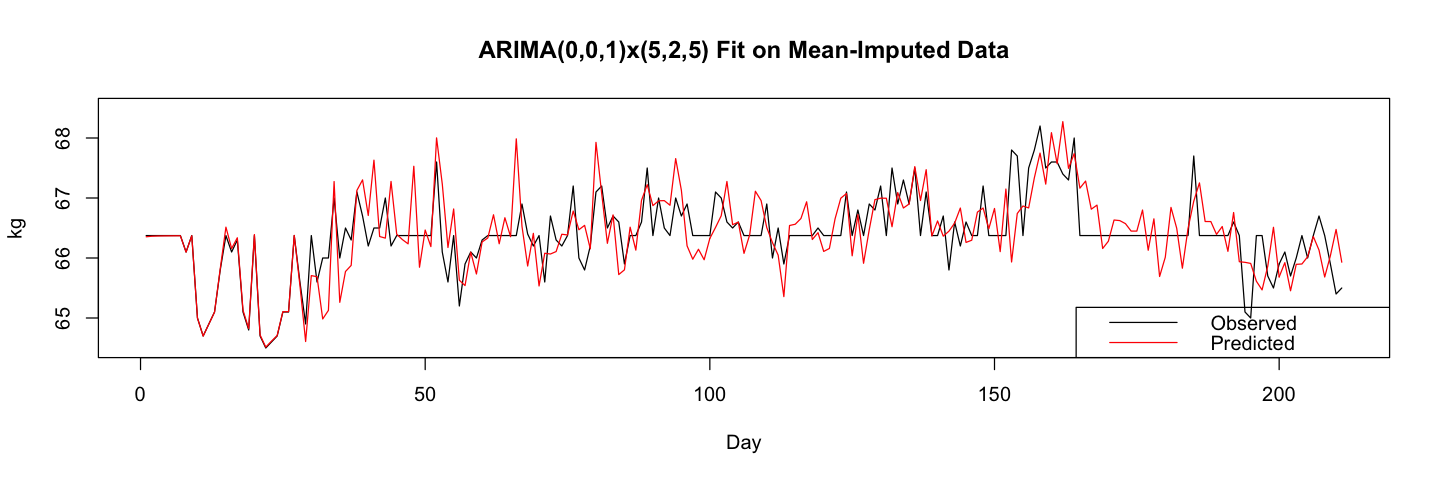

In [315]:
fit_mean <- train_mean - m_mean$residuals
plot(train_mean, type = 'l', ylim = c(64.5, 68.5), 
     xlab = 'Day', ylab = "kg", main = 'ARIMA(0,0,1)x(5,2,5) Fit on Mean-Imputed Data' )
points(fit_mean, type = 'l', col = "red")
legend("bottomright", 
       legend = c("Observed", "Predicted"), lty = 1, col = c("black", "red"), cex = 1, y.intersp=2)

The residuals are plotted below:

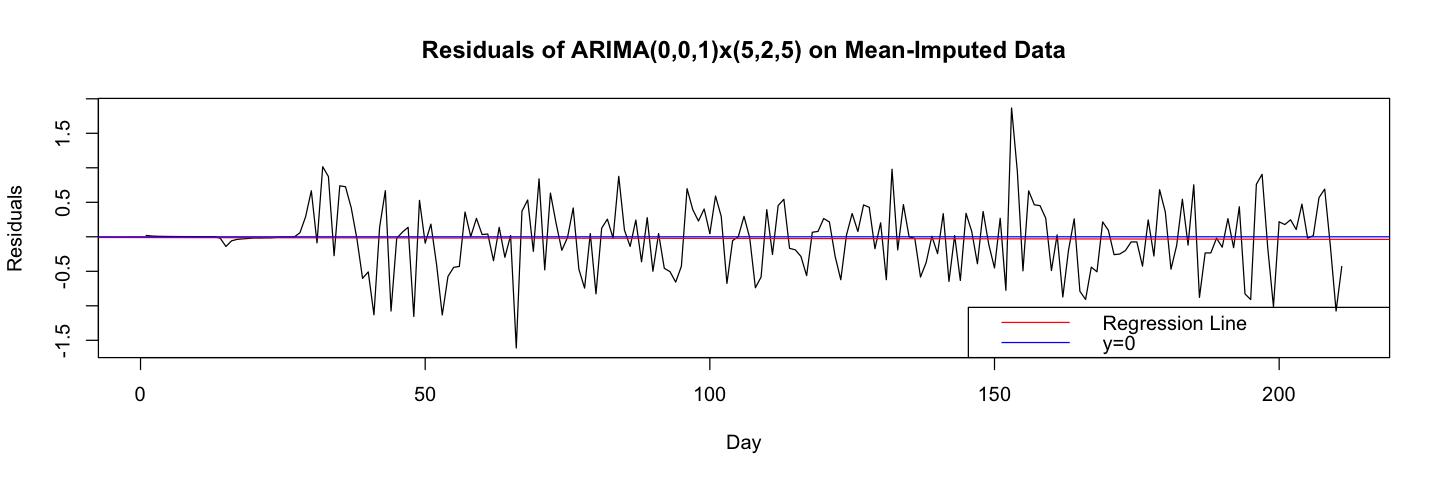

In [313]:
resid_mean = m_mean$residuals
out_resid_mean = lm(resid_mean~x)

plot(resid_mean, 
     xlab = 'Day', ylab = 'Residuals', main = "Residuals of ARIMA(0,0,1)x(5,2,5) on Mean-Imputed Data")
abline(out_resid_mean, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

The red regression line appears more or less horizontal at y=0, though the divergence is highlighted in  the zoomed-in plot below:

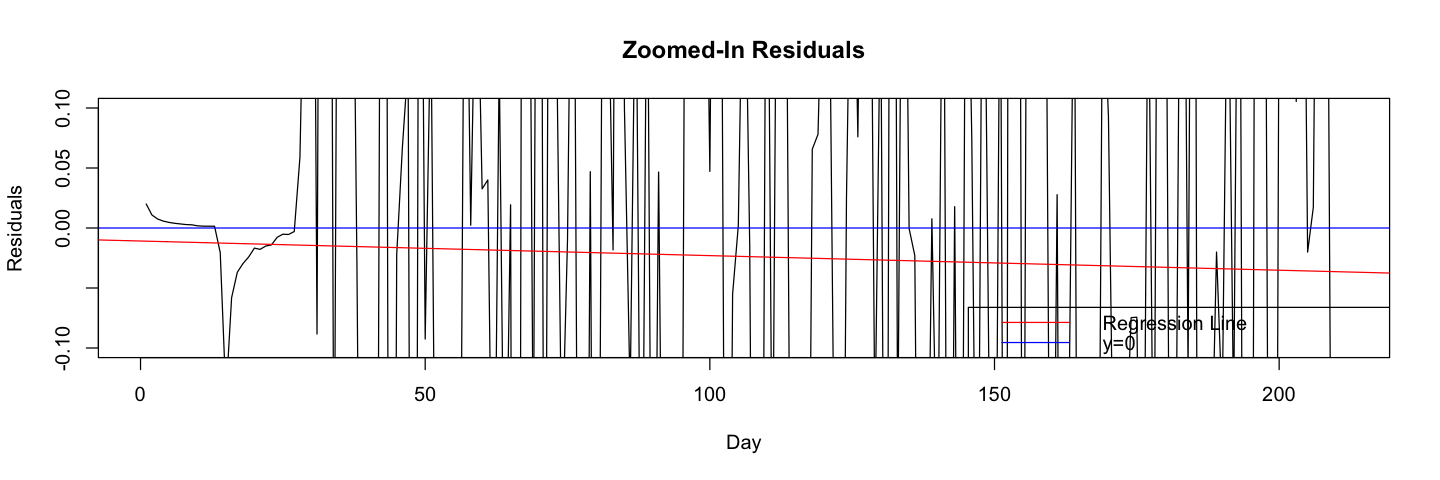

In [206]:
plot(resid_mean, ylim = c(-0.1, 0.1), 
     xlab = 'Day', ylab = 'Residuals', main = "Zoomed-In Residuals")
abline(out_resid, col = 'red')
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

The regression line is tilted downward from y=0, which indicates that there is a downward trend in the differenced mean-imputed data that the model is not capturing.

In [228]:
# Root Mean Squared Error for this model: 
rmse_mean = sum(resid_mean^2)
round(rmse_mean,2)

[1] 48.07

### LOCF Imputation

Repeating the above process of model selection with LOCF imputation, the following model is arrived at: 

In [207]:
m_locf = arima(train_locf, order = c(0,1,1), seasonal = list(order = c(5, 2, 5), period = 14))

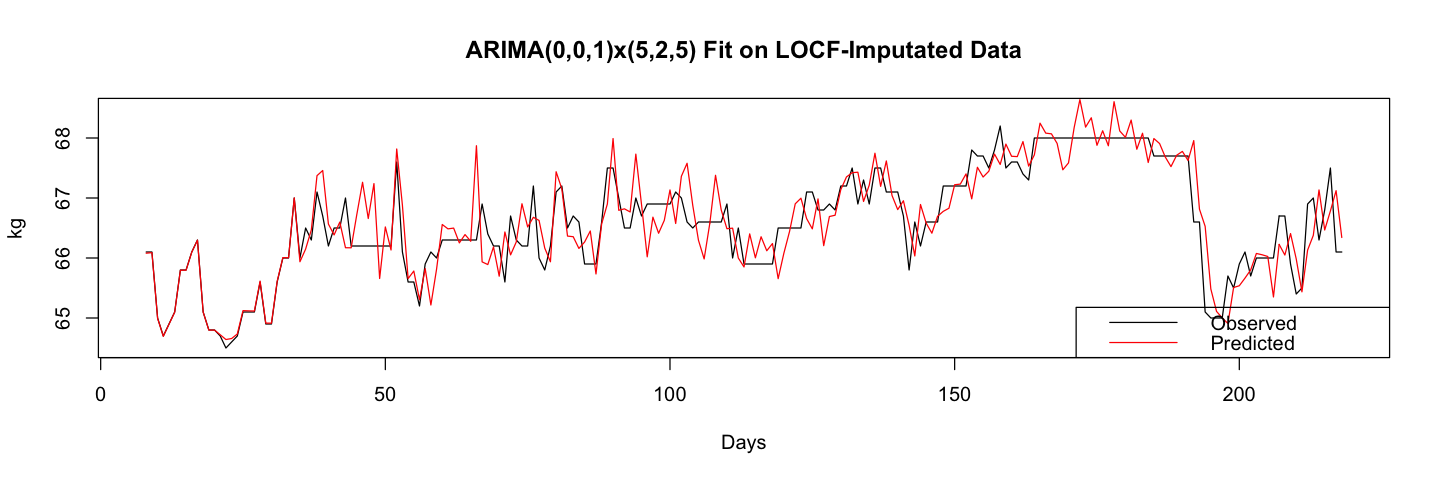

In [308]:
fit_locf <- train_locf - m_locf$residuals
plot(train_locf, type = 'l', ylim = c(64.5, 68.5),
     xlab = 'Days', ylab = "kg", main = 'ARIMA(0,0,1)x(5,2,5) Fit on LOCF-Imputated Data' )
points(fit_locf, type = 'l', col = "red")
legend("bottomright", 
       legend = c("Observed", "Predicted"), lty = 1, col = c("black", "red"), cex = 1, y.intersp=2)

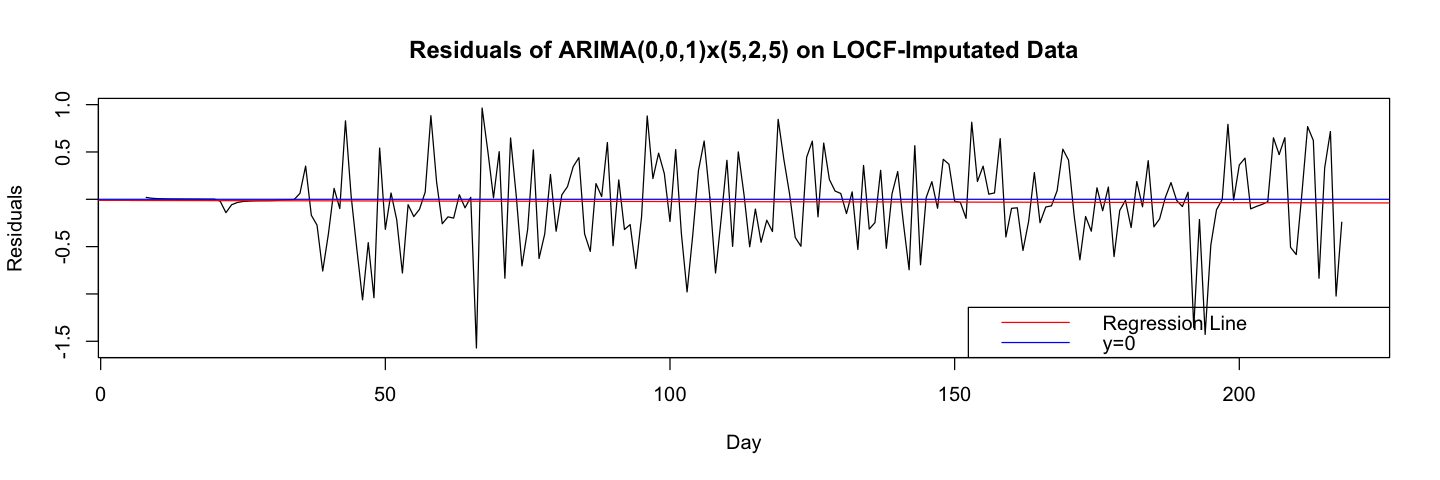

In [309]:
resid_locf = m_locf$residuals
out_resid_locf = lm(resid_locf~x)

plot(resid_locf, 
     xlab = 'Day', ylab = 'Residuals', main = "Residuals of ARIMA(0,0,1)x(5,2,5) on LOCF-Imputated Data")
abline(out_resid_lin, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

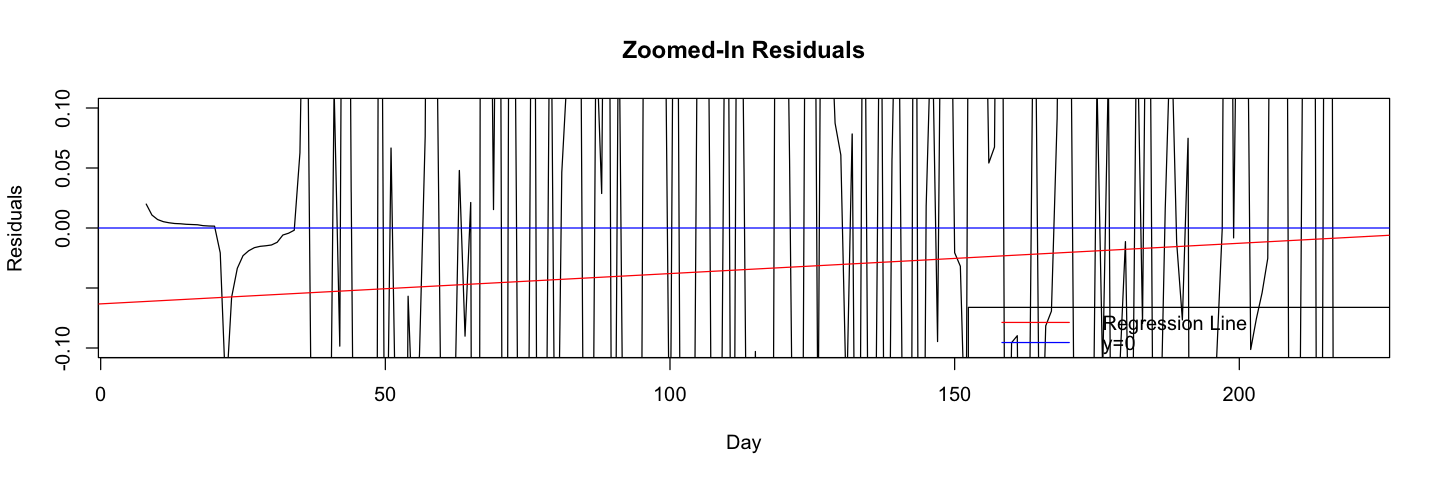

In [334]:
plot(resid_locf, ylim = c(-0.1, 0.1),  
     xlab = 'Day', ylab = 'Residuals', main = "Zoomed-In Residuals")
abline(out_resid_locf, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

The regression line is upwardly tilted, which indicates there is an upward trend in the LOCF-imputed data that the model is not capturing.

In [229]:
# Root Mean Squared Error for this model: 
rmse_locf = sum(resid_locf^2)
round(rmse_locf,2)

[1] 39.62

### Linear Interpolation

In [188]:
m_lin = arima(train_lin, order = c(0,1,1), seasonal = list(order = c(5, 2, 5), period = 14))

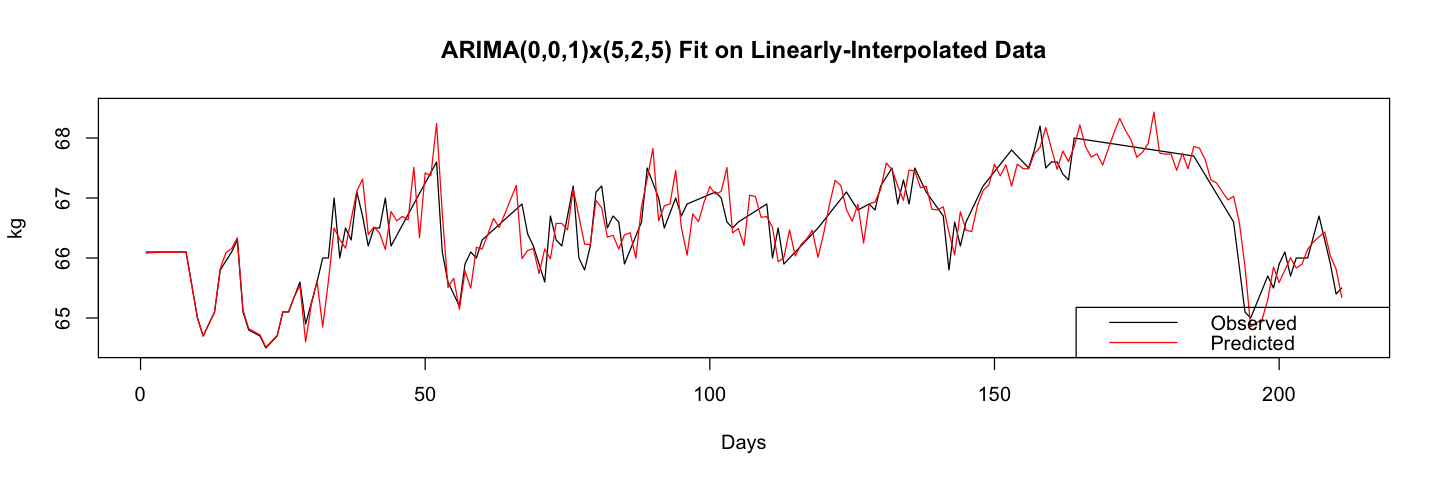

In [318]:
fit_lin <- train_lin - m_lin$residuals
plot(train_lin, type = 'l', ylim = c(64.5, 68.5),
     xlab = 'Days', ylab = "kg", main = 'ARIMA(0,0,1)x(5,2,5) Fit on Linearly-Interpolated Data' )
points(fit_lin, type = 'l', col = "red")
legend("bottomright", 
       legend = c("Observed", "Predicted"), lty = 1, col = c("black", "red"), cex = 1, y.intersp=2)

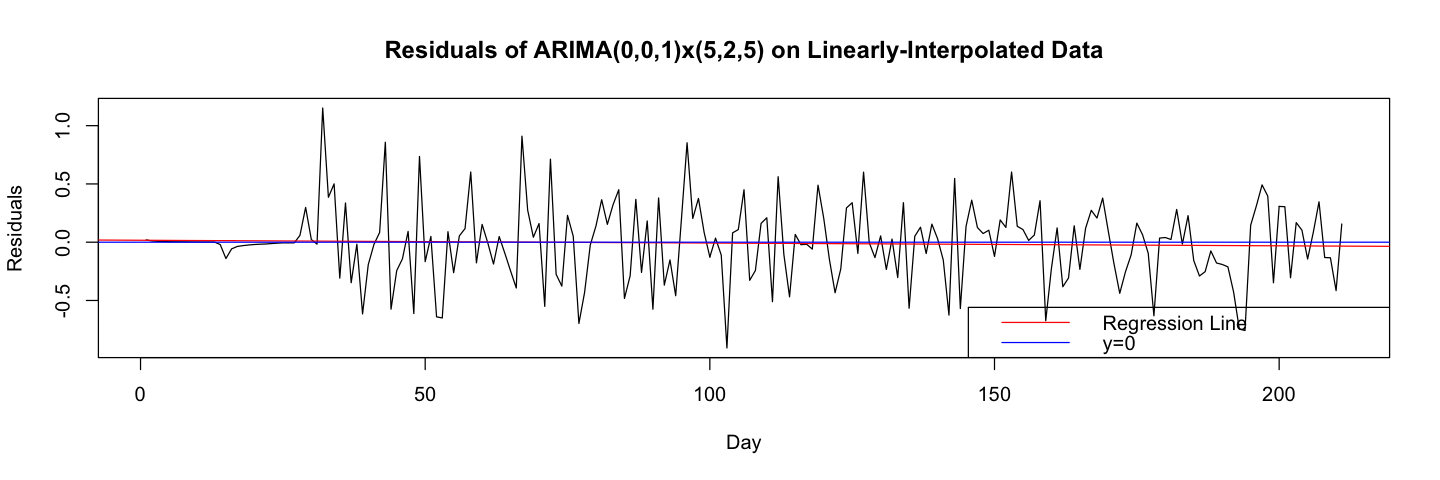

In [331]:
resid_lin = m_lin$residuals
out_resid_lin = lm(resid_lin~x)

plot(resid_lin, 
     xlab = 'Day', ylab = 'Residuals', 
     main = "Residuals of ARIMA(0,0,1)x(5,2,5) on Linearly-Interpolated Data")
abline(out_resid_lin, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

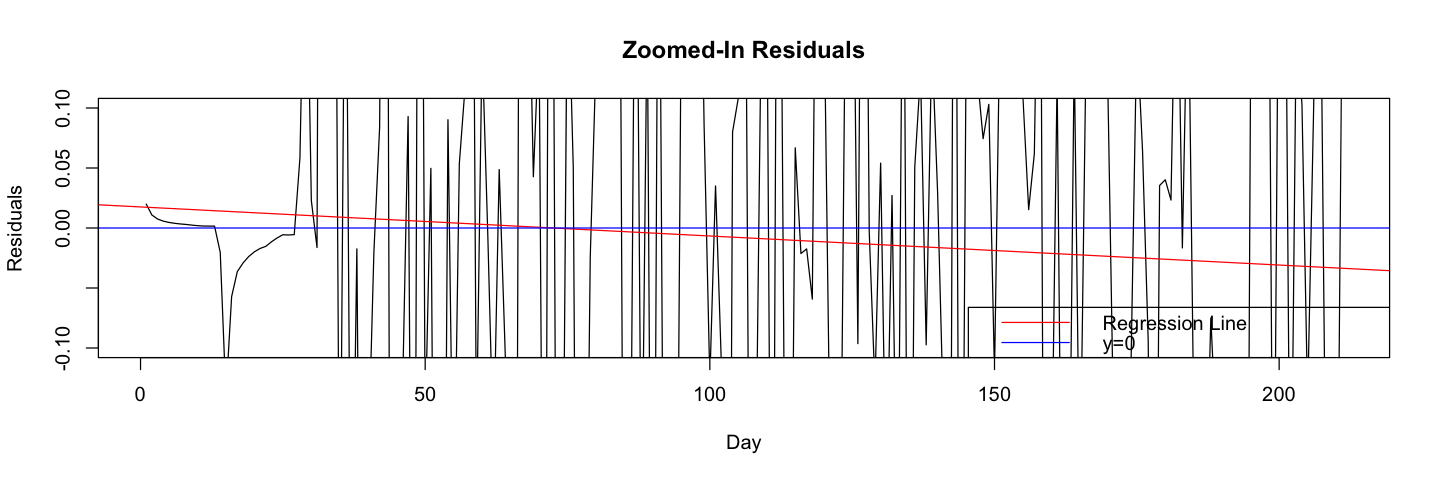

In [332]:
plot(resid_lin, ylim = c(-0.1, 0.1),
     xlab = 'Day', ylab = 'Residuals', main = "Zoomed-In Residuals")
abline(out_resid_lin, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

There is a downward trend in the linearly-interpolated data that the model is not capturing, though the RMSE shows that this model is still doing better than mean-imputed model.

In [333]:
# Root Mean Squared Error for this model: 
rmse_lin = sum(resid_lin^2)
round(rmse_lin,2)

[1] 22.48

Linear interpolation yields the smallest RMSE value on the training data. What about on the test set? 

### Validation

In [259]:
fore_mean = forecast(m_mean, ndays)
preds_mean = fore_mean[['mean']]
preds_mean_up = fore_mean[['upper']][,2]
preds_mean_low = fore_mean[['lower']][,2]

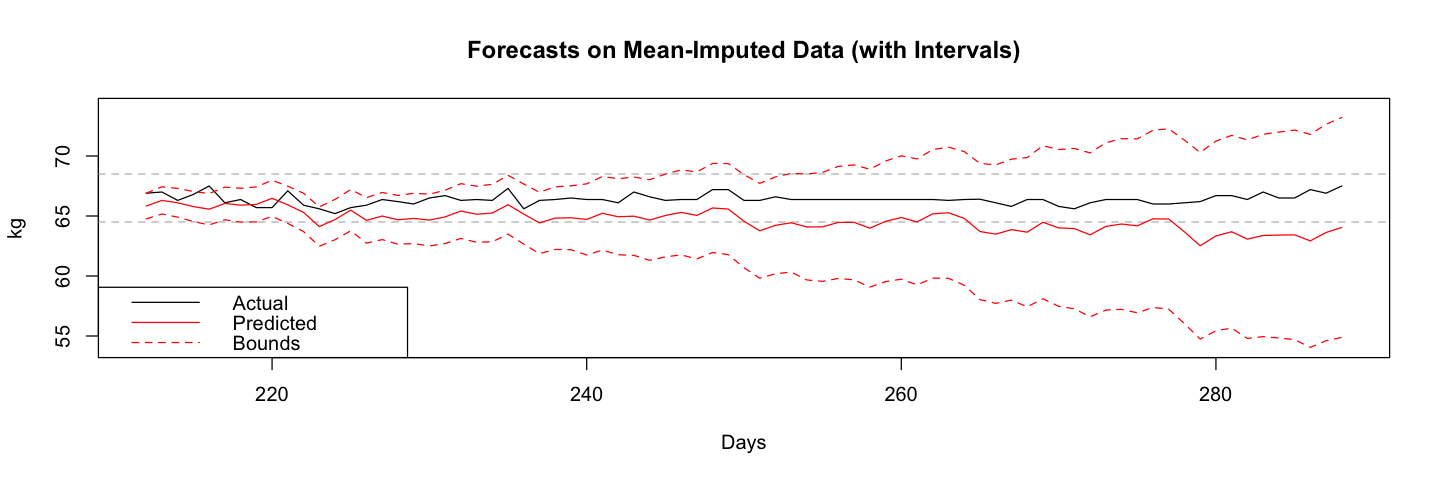

In [288]:
plot(test_mean, ylim = c(54, 74), 
     xlab = 'Days', ylab = 'kg', main = 'Forecasts on Mean-Imputed Data (with Intervals)')
abline(h = 64.5, lty = 'dashed', col = 'grey')
abline(h = 68.5, lty = 'dashed', col = 'grey')
points(preds_mean, col = 'red', typ = 'l')
points(preds_mean_up, col = 'red', typ = 'l', lty = 'dashed')
points(preds_mean_low, col = 'red', typ = 'l', lty = 'dashed')
legend('bottomleft', 
       legend=c("Actual", 'Predicted', 'Bounds'), lty= c('solid', 'solid', 'dashed'), 
       col = c('black', 'red', 'red'), y.intersp=2)

The plot above shows the observed values from days 212 to 288 (black), the predicted values (solid red), and the upper and lower bounds on this prediction (dashed red). The two dashed grey lines mark the boundaries used in all plots in the training stage above: 64.5-68.5kg. A couple of things to note: 

- The prediction interval widens as we predict further forward in time. This is because the prediction for day 260 depends on the prediction for day 259, which depends on the prediction for day 258, etc., back to the first day in our validation set (day 212). Prediction uncertainty is thus compounded day after day, causing the interval grows. 
- The lower and upper bounds are frankly not very helpful. Consider that at day 220 (after 8 days of prediction), the lower bound surpasses the lowest value (my) weight has taken. From a practical point of view, it is as good as no information to tell me that (my) weight is going to be between 60-70kg (let alone 55-75kg), when historical data has told me it does not fluctuate beyond 64.5-68kg.

Below, we consider point forecasts only:

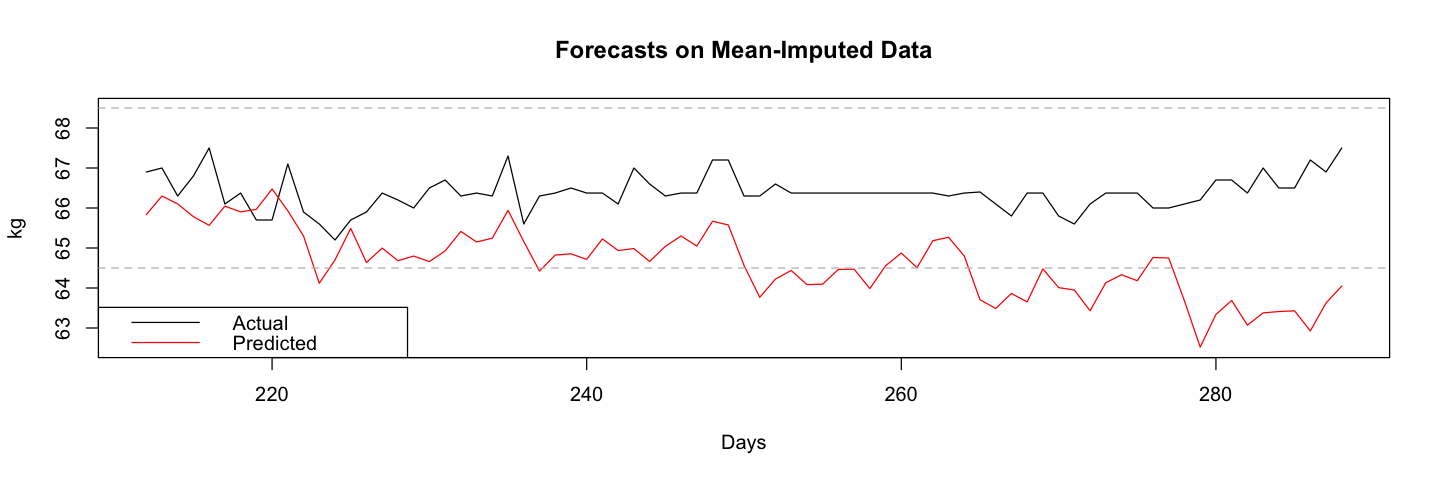

In [286]:
plot(test_mean, ylim = c(62.5, 68.5), 
     xlab = 'Days', ylab = 'kg', main = 'Forecasts on Mean-Imputed Data')
points(preds_mean, col = 'red', typ = 'l')
abline(h = 64.5, lty = 'dashed', col = 'grey')
abline(h = 68.5, lty = 'dashed', col = 'grey')
legend('bottomleft', 
       legend=c("Actual", 'Predicted'), lty= c('solid', 'solid'), col = c('black', 'red', 'red'), y.intersp=2)

In [323]:
rmse_mean_fore = sum((test_mean-preds_mean)^2)
round(rmse_mean_fore, 2)

[1] 300.93

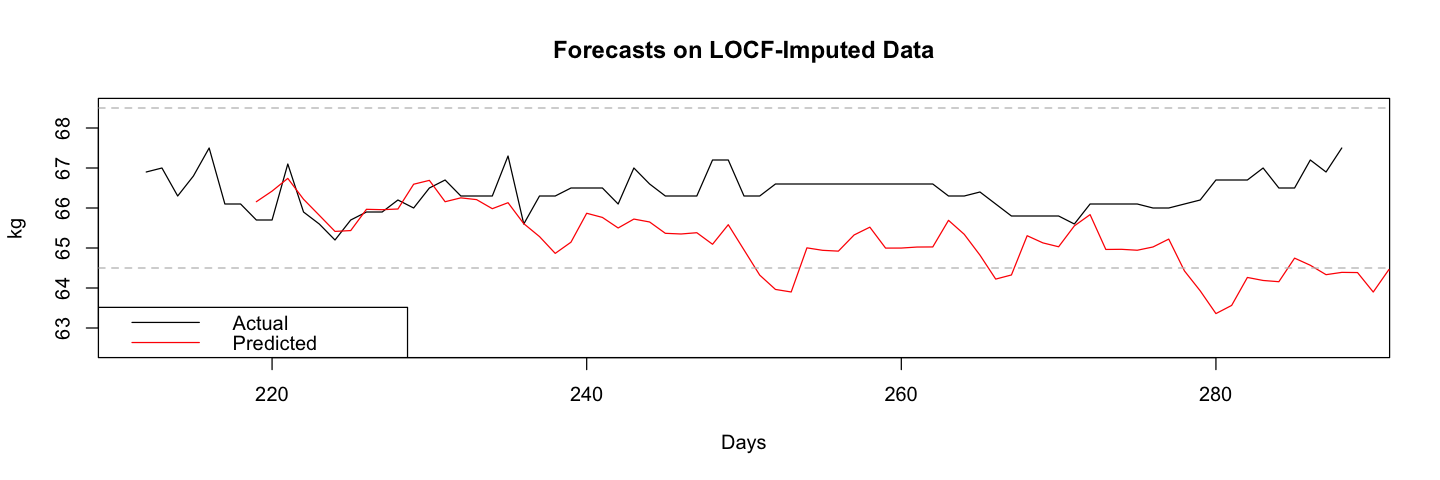

In [292]:
fore_locf = forecast(m_locf, ndays)
preds_locf = fore_locf[['mean']]

plot(test_locf, ylim = c(62.5, 68.5), 
     xlab = 'Days', ylab = 'kg', main = 'Forecasts on LOCF-Imputed Data')
points(preds_locf, col = 'red', typ = 'l')
abline(h = 64.5, lty = 'dashed', col = 'grey')
abline(h = 68.5, lty = 'dashed', col = 'grey')
legend('bottomleft', 
       legend=c("Actual", 'Predicted'), lty= c('solid', 'solid'), col = c('black', 'red'), y.intersp=2)

In [324]:
rmse_locf_fore = sum((test_locf-preds_locf)^2)
round(rmse_locf_fore, 2)

[1] 153.55

Because LOCF requires... the forecast is staggered by 7 days.

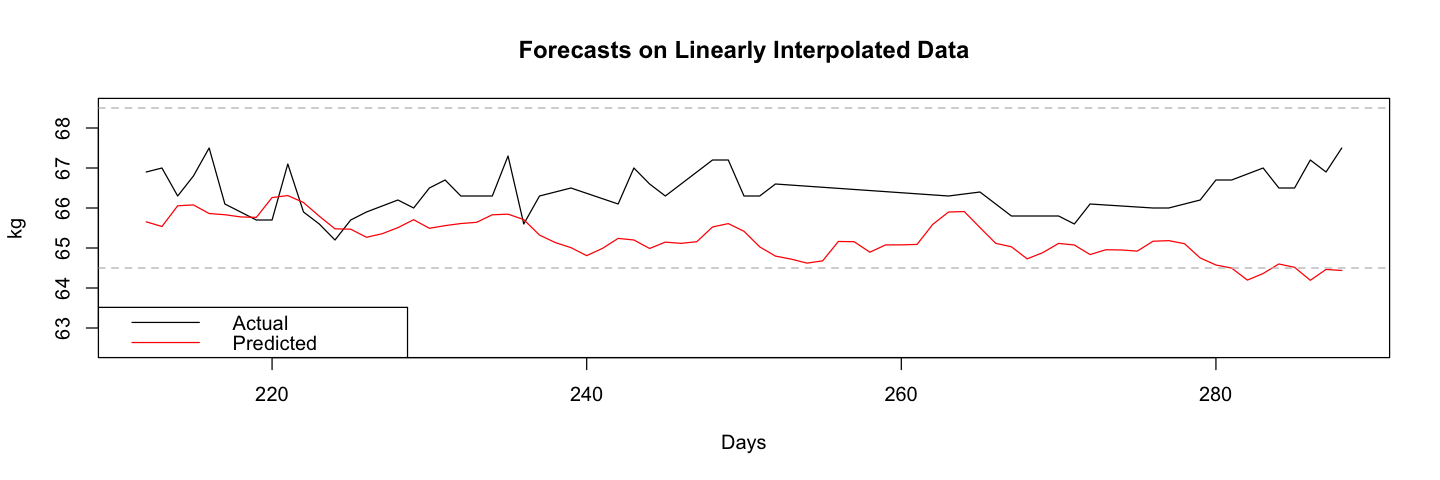

In [291]:
fore_lin = forecast(m_lin, ndays)
preds_lin = fore_lin[['mean']]

plot(test_lin, ylim = c(62.5, 68.5), 
     xlab = 'Days', ylab = 'kg', main = 'Forecasts on Linearly Interpolated Data')
points(preds_lin, col = 'red', typ = 'l')
abline(h = 64.5, lty = 'dashed', col = 'grey')
abline(h = 68.5, lty = 'dashed', col = 'grey')
legend('bottomleft', 
       legend=c("Actual", 'Predicted'), lty= c('solid', 'solid'), col = c('black', 'red', 'red'), y.intersp=2)

In [325]:
rmse_lin_fore = sum((test_lin-preds_lin)^2)
round(rmse_lin_fore, 2)

[1] 140.45

Just as with the training set, linear interpolation yields the lowest RMSE on the validation set. 

A visual comparison shows that while all models underestimate weight, linear interpolation yields forecasts that rarely do not exceed the training bounds until day 280 (69 days out), whereas the other two methods exceed the bounds much earlier.

### Prediction

Retraining this model on the full dataset and forecasting into the future:

In [329]:
m_lin_full = arima(ts_weight_lin, order = c(0,1,1), seasonal = list(order = c(5, 2, 5), period = 14))

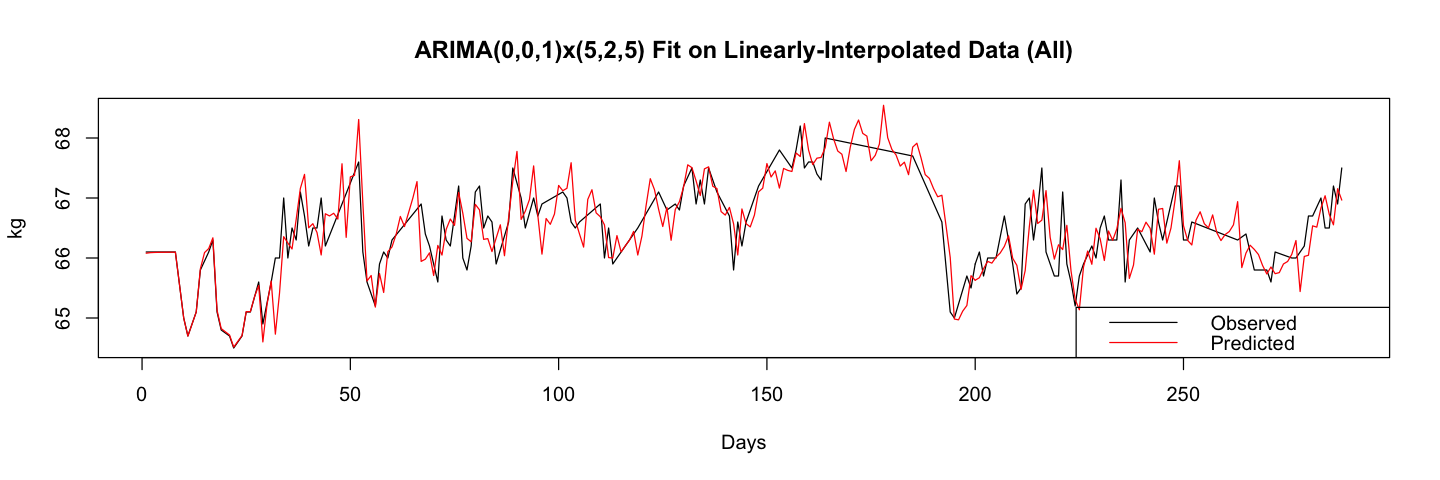

In [330]:
fit_lin_full <- ts_weight_lin - m_lin_full$residuals
plot(ts_weight_lin, type = 'l', ylim = c(64.5, 68.5),
     xlab = 'Days', ylab = "kg", main = 'ARIMA(0,0,1)x(5,2,5) Fit on Linearly-Interpolated Data (All)' )
points(fit_lin_full, type = 'l', col = "red")
legend("bottomright", 
       legend = c("Observed", "Predicted"), lty = 1, col = c("black", "red"), cex = 1, y.intersp=2)

The model appears to follow the data pretty well.

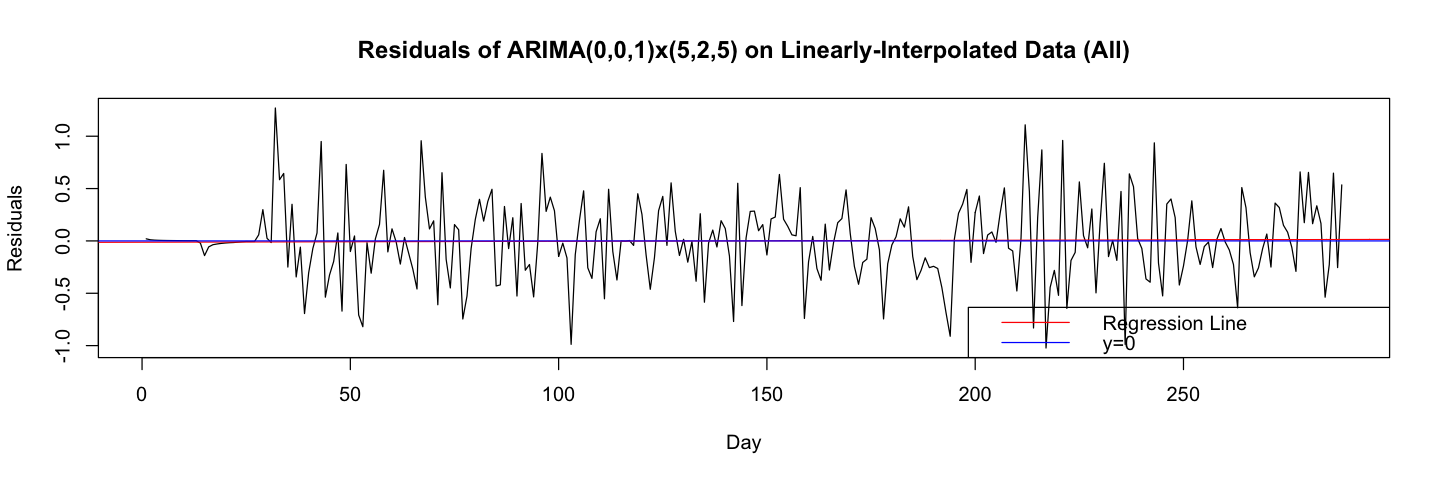

In [338]:
resid_lin_full = m_lin_full$residuals
x_full = c(1:length(resid_lin_full))
out_resid_lin_full = lm(resid_lin_full~x_full)

plot(resid_lin_full, 
     xlab = 'Day', ylab = 'Residuals', 
     main = "Residuals of ARIMA(0,0,1)x(5,2,5) on Linearly-Interpolated Data (All)")
abline(out_resid_lin_full, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

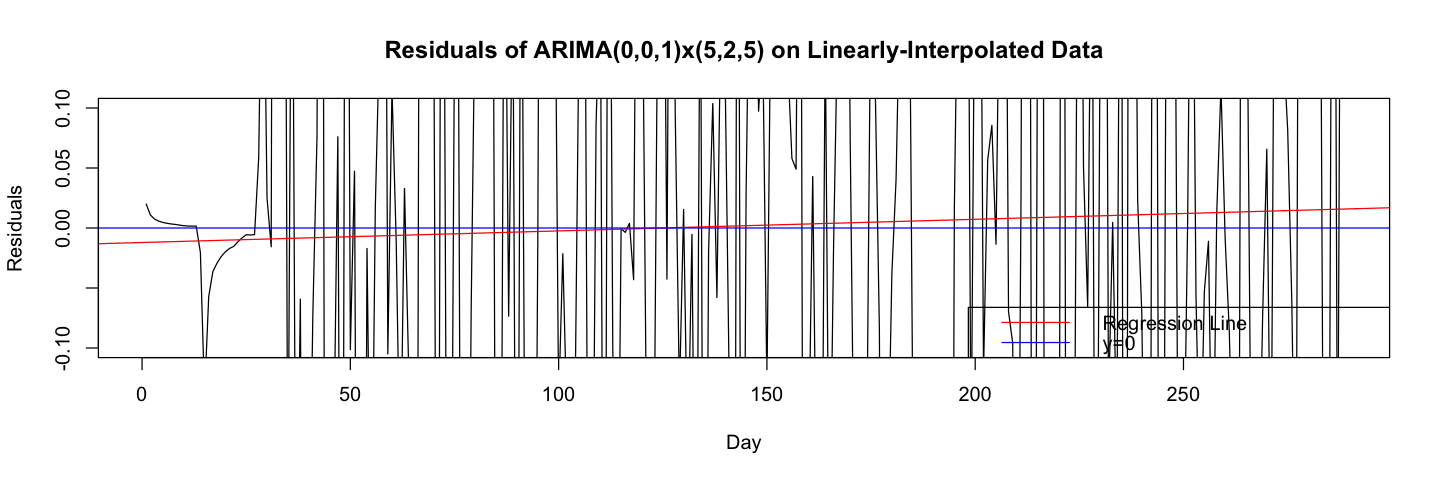

In [340]:
plot(resid_lin_full, ylim = c(-0.1, 0.1),
     xlab = 'Day', ylab = 'Residuals', 
     main = "Residuals of ARIMA(0,0,1)x(5,2,5) on Linearly-Interpolated Data")
abline(out_resid_lin_full, col = "red")
abline(h=0, col = 'blue')
legend('bottomright', 
       legend=c("Regression Line", 'y=0'), lty= c('solid', 'solid'), col = c('red', 'blue'), y.intersp=2)

In [350]:
# RMSE of new model on the training set
rmse_lin_full_sub = sum(resid_lin_full[1:211]^2)
round(rmse_lin_full_sub,2)

[1] 25.92

In [342]:
# RMSE of new model on all data 
rmse_lin_full = sum(resid_lin_full^2)
round(rmse_lin_full,2)

[1] 40.99

The close-up of the residuals and RMSE values for this model suggest that it does pretty well. It has somewhat "overcorrected" for the previously missed downward trend in the data and now appears to miss an upward trend. Nonetheless, the RMSE on the training set (days 1 to 211) has improved and the RMSE on the full dataset is approximately equal to that yielded by mean-imputation and LOCF-imputation on just the training days.

In [368]:
fore_lin_full = forecast(m_lin_full, 77)
preds_lin_full = fore_lin_full[['mean']]
preds_lin_full_high = fore_lin_full[['upper']][,2]
preds_lin_full_low = fore_lin_full[['lower']][,2]

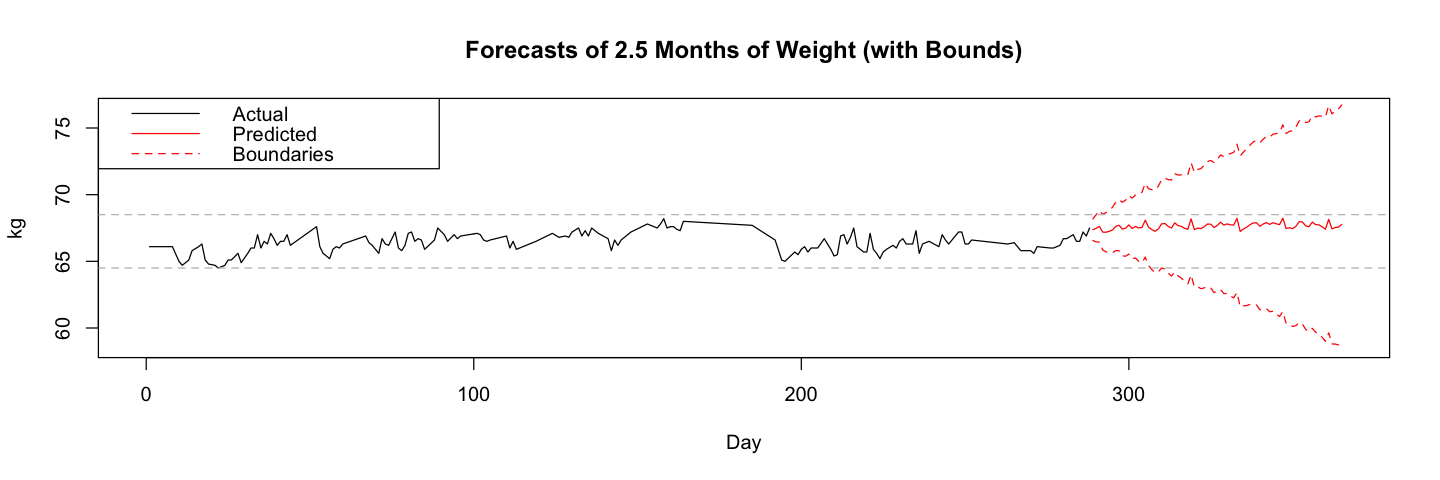

In [390]:
plot(ts_weight_lin, xlim = c(0, 365), ylim = c(58.5,76.5)
     , xlab = 'Day', ylab = 'kg', main = "Forecasts of 2.5 Months of Weight (with Bounds)")
points(preds_lin_full, typ = 'l', col = 'red')
points(preds_lin_full_high, typ = 'l', col = 'red', lty = 'dashed')
points(preds_lin_full_low, typ = 'l', col = 'red', lty = 'dashed')
abline(h = 64.5, lty = 'dashed', col = 'grey')
abline(h = 68.5, lty = 'dashed', col = 'grey')
legend('topleft', 
       legend=c("Actual", 'Predicted', 'Boundaries'), 
       lty= c('solid', 'solid', 'dashed'), col = c('black', 'red', 'red'), y.intersp=2)

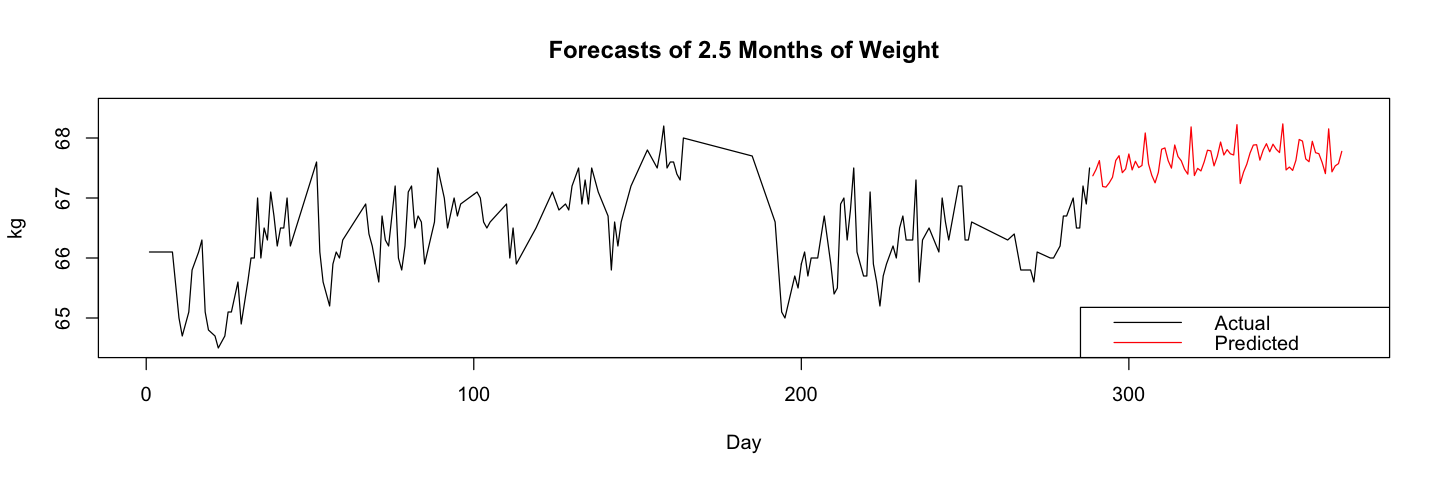

In [388]:
plot(ts_weight_lin, xlim = c(0, 365), ylim = c(64.5, 68.5),
     xlab = 'Day', ylab = 'kg', main = "Forecasts of 2.5 Months of Weight"
    )
points(preds_lin_full, typ = 'l', col = 'red')
legend('bottomright', 
       legend=c("Actual", 'Predicted'), lty= c('solid', 'solid'), col = c('black', 'red'), y.intersp=2)

Here again, the prediction intervals, which bound weight between 58.5-76.5kg for the next 2.5 months, are  not helpful given our prior knowledge of the range that (my) weight takes. The point estimates on the other hand suggest suggest that weight will fluctuate between 67-68kg for the next 2.5 months. This seems realistic (even if I hope it dips lower), even if the pattern exhibited seems rather simplistic. 

As a next step, let's make a more sophisticated model by including additional variables that seem (through first-hand experience) to be correlated with weight: stage in the hormonal cycle and stage in the school term.

## Multivariate Modelling


### ARIMAX

### VARX

### Validation

### Prediction

## Conclusion